In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import import_ipynb
import Lib.Functions as fc
import Lib.Feature_Selection as ft
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from /Users/admin/Desktop/[ICK]_UserAcquisition/1. Code & Data/2. Modelling/Lib/Functions.ipynb
importing Jupyter notebook from /Users/admin/Desktop/[ICK]_UserAcquisition/1. Code & Data/2. Modelling/Lib/Feature_Selection.ipynb


In [2]:
demographics = pd.read_csv('ICKDemographicsPipeline_v260423.csv')
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173193 entries, 0 to 173192
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   UserID          173193 non-null  object 
 1   TotalChild      173193 non-null  int64  
 2   MedianChildAge  173193 non-null  float64
 3   No.Female       173193 non-null  float64
 4   No.Male         173193 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.6+ MB


In [3]:
df_pay = pd.read_csv('RealPaymentsType.csv')
df_pay['UserJoinedDate'] = df_pay['UserJoinedDate'].map(lambda x: x[: 19])
df_pay['UserJoinedDate'] = pd.to_datetime(df_pay['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')
df_pay['JoinMonth'] = df_pay['UserJoinedDate'].dt.month

payment = df_pay[['UserID', 'UserJoinedDate', 'gapday']]
payment.shape

(265308, 3)

In [4]:
detail = pd.read_csv('Engagement_detail_learn_updated.csv')
detail['InteractionLearn'] = detail['UsageTime'] * detail['Records']

detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506702 entries, 0 to 1506701
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   EventDate                  1506702 non-null  object 
 1   nth_day_from_registration  1506702 non-null  int64  
 2   UserID                     1506702 non-null  object 
 3   SubjectName                1506702 non-null  object 
 4   IsCompleted                1506702 non-null  int64  
 5   UsageTime                  1506702 non-null  float64
 6   Records                    1506702 non-null  int64  
 7   InteractionLearn           1506702 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 92.0+ MB


In [5]:
detail = pd.merge(left=detail,
                  right=payment,
                  how='left',
                  on='UserID')
detail.shape

(1506702, 10)

In [6]:
firstday_learn = pd.DataFrame(detail.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday_learn.columns = ['UserID', 'MinFirstDay']

firstday_learn['ZeroDay'] = firstday_learn['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday_learn.shape

(153340, 3)

In [7]:
detail = pd.merge(left=detail,
                  right=firstday_learn,
                  how='left',
                  on='UserID')

detail.loc[detail['gapday'].isnull(), 'gapday'] = 'no_pay'
detail.shape

(1506702, 12)

In [8]:
def DetailBasedNthDay(dataframe, nthday=5):
    pay = dataframe.loc[dataframe['gapday'] != 'no_pay']
    
    mask0 = pay['ZeroDay'] == 'zero'
    mask1 = pay['nth_day_from_registration'] <= nthday
    df0 = pay[mask0 & mask1]
    
    df0['CutoffDay'] = df0['MinFirstDay'] + nthday
    df0['ScaleActionDay'] = df0['nth_day_from_registration'] - 0
    df0['ScaleGapday'] = df0['gapday'] - df0['MinFirstDay']
    
    mask2 = pay['ZeroDay'] != 'zero'
    others = pay[mask2]
    others['CutoffDay'] = others['MinFirstDay'] + nthday
    
    mask3 = others['nth_day_from_registration'] <= others['CutoffDay']
    df1 = others[mask3]
    df1['ScaleActionDay'] = df1['nth_day_from_registration'] - df1['MinFirstDay']
    df1['ScaleGapday'] = df1['gapday'] - df1['MinFirstDay']
    
    purchaser = pd.concat([df0, df1], ignore_index=True)
    
    free = dataframe.loc[dataframe['gapday'] == 'no_pay']
    f0 = free['ZeroDay'] == 'zero'
    f1 = free['nth_day_from_registration'] <= nthday
    free0 = free[f0 & f1]
    
    free0['CutoffDay'] = free0['MinFirstDay'] + nthday
    free0['ScaleActionDay'] = free0['nth_day_from_registration'] - 0
    free0['ScaleGapday'] = free0['gapday']
    
    non0 = free.loc[free['ZeroDay'] != 'zero']
    non0['CutoffDay'] = non0['MinFirstDay'] + nthday
    f3 = non0['nth_day_from_registration'] <= non0['CutoffDay']
    free1 = non0[f3]
    free1['ScaleActionDay'] = free1['nth_day_from_registration'] - free1['MinFirstDay']
    free1['ScaleGapday'] = free1['gapday']
    
    non_purchaser = pd.concat([free0, free1], ignore_index=True)
    
    data = pd.concat([purchaser, non_purchaser], ignore_index=True)
    
    return data

In [9]:
learn_detail = DetailBasedNthDay(detail, nthday=5)

In [10]:
content_learn = learn_detail.pivot_table(index = 'UserID',
                                         columns = 'SubjectName',
                                         values = ['IsCompleted', 'UsageTime', 'Records', 'InteractionLearn'],
                                         aggfunc = np.sum).reset_index()

cols = ['UserID',
        'InteractionEnglish', 'InteractionMath', 'InteractionPhonics', 'InteractionVietnamese',
        'IsCompletedEnglish', 'IsCompletedMath','IsCompletedPhonics', 'IsCompletedVietnamese',
        'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
        'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

content_learn.columns = cols

for col in content_learn.columns[1:]:
    content_learn.loc[content_learn[col].isnull(), col] = 0
    
content_learn.shape

(153340, 17)

In [11]:
engage = pd.read_csv('RealEngagements_updated.csv')
engage['UserJoinedDate'] = engage['UserJoinedDate'].map(lambda x: x[: 19])
engage['UserJoinedDate'] = pd.to_datetime(engage['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')

engage['lastuse'] = engage['lastuse'].map(lambda x: x[: 19])
engage['lastuse'] = pd.to_datetime(engage['lastuse'], format = '%Y-%m-%d %H:%M:%S')

engage['firstuse'] = engage['firstuse'].map(lambda x: x[: 19])
engage['firstuse'] = pd.to_datetime(engage['firstuse'], format = '%Y-%m-%d %H:%M:%S')

engage['firstuse_hour'] = engage['firstuse'].dt.hour
engage['lastuse_hour'] = engage['lastuse'].dt.hour
engage['lastuse_day'] = engage['lastuse'].dt.day
engage['lastuse_dayofweek'] = engage['lastuse'].dt.dayofweek
engage['JoinMonth'] = engage['UserJoinedDate'].dt.month

engage.shape

(1638631, 17)

In [12]:
engage = pd.merge(left=engage,
                  right=payment[['UserID', 'gapday']],
                  on='UserID',
                  how='left')
engage.shape

(1638631, 18)

In [13]:
brand = engage['DeviceBrand'].value_counts()

Big = brand[brand >= 100000].index.tolist()
Medium = brand[(brand >= 10000) & (brand < 100000)].index.tolist()
Small = brand[brand < 10000].index.tolist()

def TransformBrand(x):
    if x in Big:
        return 'Big'
    elif x in Medium:
        return 'Medium'
    else:
        return 'Small'

engage['TypeBrand'] = engage['DeviceBrand'].map(lambda x: TransformBrand(x))

engage.loc[engage['gapday'].isnull(), 'gapday'] = 'no_pay'

In [14]:
firstday = pd.DataFrame(engage.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday.columns = ['UserID', 'MinFirstDay']

firstday['ZeroDay'] = firstday['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday.shape

(163040, 3)

In [15]:
engage = pd.merge(left=engage,
                  right=firstday,
                  how='left',
                  on='UserID')
engage.shape

(1638631, 21)

In [16]:
action = DetailBasedNthDay(engage, nthday=5)

In [17]:
action.shape

(495350, 24)

In [18]:
Recency = lambda x: 6 - max(x)

Frequency_content = lambda x: len(x.unique()) # tan suat dang nhap trong 2 ngay
Frequency_payment = lambda x: sum(x)# so lan vao trang thanh toan trong 2 ngay

Monetary_usage = lambda x: sum(x)  # tong thoi gian dung app trong 7 ngay (minutes)
Monetary_record = lambda x: sum(x) # tong so records trong 7 ngay

Mode_firstuse_hour = lambda x: x.mode()[0]
Mode_lastuse_day = lambda x: x.mode()[0]
Mode_lastuse_hour = lambda x: x.mode()[0]
Mode_lastuse_dayofweek = lambda x: x.mode()[0]

active = action.groupby('UserID').agg({'ScaleActionDay': Recency,
                                     'firstuse': Frequency_content,
                                     'payment_screen_time': Frequency_payment,
                                     'UsageTime': Monetary_usage,
                                     'Records': Monetary_record,
                                     'firstuse_hour': Mode_firstuse_hour,
                                     'lastuse_hour': Mode_lastuse_hour,
                                     'lastuse_day': Mode_lastuse_day,
                                     'lastuse_dayofweek': Mode_lastuse_dayofweek}).reset_index()

cols = ['UserID', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 
        'TotalUsageTime','TotalRecords', 'ModeFirstHour', 'ModeLastHour', 'ModeLastDay', 'ModeDayofweek']

active.columns = cols

In [19]:
Median_usage = lambda x: x.median()
Median_record = lambda x: x.median()
Median_payment_screentime = lambda x: x.median()

active_median = action.groupby('UserID').agg({'UsageTime': Median_usage,
                                            'Records': Median_record,
                                            'payment_screen_time': Median_payment_screentime}).reset_index()

cols = ['UserID', 'MedianUsageTime', 'MedianRecord', 'MedianPaymentScreen']

active_median.columns = cols

In [20]:
action['Counting'] = [1] * action.shape[0]

brand = action.pivot_table(index = 'UserID',
                             columns = 'TypeBrand',
                             values = ['Counting'],
                             aggfunc = np.sum).reset_index()

brand_cols = ['UserID', 'BigBrand', 'MediumBrand', 'SmallBrand']
        
brand.columns = brand_cols

for col in brand.columns[1:]:
    brand.loc[brand[col].isnull(), col] = 0
    
brand.shape

(163040, 4)

In [21]:
content_sum = action.pivot_table(index = 'UserID',
                                    columns = 'ActionType',
                                    values = ['UsageTime', 'Records'],
                                    aggfunc = np.sum).reset_index()

new_cols = ['UserID',
            'RecordDiscovery', 'RecordEntertainment', 'RecordLearn',
            'UsageTimeDiscovery', 'UsageTimeEntertainment', 'UsageTimeLearn']

content_sum.columns = new_cols

for col in content_sum.columns[1:]:
    content_sum.loc[content_sum[col].isnull(), col] = 0

In [22]:
Number_of_device = lambda x: len(x.unique())

demo = action.groupby('UserID').agg({'TypeBrand': Number_of_device}).reset_index()

demo.columns = ['UserID', 'No.TypeBrand']

demo

,UserID,No.TypeBrand
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,1
1,00007f9f-be36-4a0d-a2a8-167231588625,1
2,00015787-1ed9-45b9-9c5f-2613e2ca8409,1
3,0001f256-edcf-4980-b84b-85d85745fd0f,1
4,000234a9-a233-4476-9023-9b83f331b7f6,1
...,...,...
163035,fffdf7d4-a6c3-46e6-bbb7-045211d7007f,1
163036,ffff2125-692f-4755-bfcd-59219e49d6d6,1
163037,ffff56de-effe-4b67-9990-33240f51c866,1
163038,ffff81a7-4938-4d26-8492-bd8e4acc2a19,1


In [23]:
print(active.shape)
print(content_sum.shape)
print(active_median.shape)
print(brand.shape)
print(content_learn.shape)
print(demo.shape)
print(demographics.shape)

(163040, 10)
(163040, 7)
(163040, 4)
(163040, 4)
(153340, 17)
(163040, 2)
(173193, 5)


In [24]:
data_list = [active, demographics, demo, brand, content_learn, content_sum, active_median, 
             df_pay[['UserID', 'firstPaymentType', 'JoinMonth','gapday']]]

final = active.copy()

for x in data_list[1:]:
    final = pd.merge(left=final,
                     right=x,
                     how='left',
                     on='UserID')
final.shape

(163040, 46)

In [25]:
null_idx = final.loc[final['TotalChild'].isnull()].index.tolist()

final = final.drop(null_idx)
final.shape

(158981, 46)

In [26]:
data = final.copy()

In [27]:
learning_detail = ['InteractionEnglish', 'InteractionMath','InteractionPhonics', 'InteractionVietnamese', 
                   'IsCompletedEnglish', 'IsCompletedMath', 'IsCompletedPhonics', 'IsCompletedVietnamese',
                   'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
                   'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

for col in learning_detail:
    data.loc[data[col].isnull(), col] = 0

In [28]:
data['AvgTimePerCompletion'] = data['TotalUsageTime'] / data['TotalRecords']
data['InteractionGeneral'] = data['TotalUsageTime'] * data['TotalRecords']
data['InteractionLearn'] = data['UsageTimeLearn'] * data['RecordLearn']
data['InteractionDiscovery'] = data['UsageTimeDiscovery'] * data['RecordDiscovery']
data['InteractionEntertainment'] = data['UsageTimeEntertainment'] * data['RecordEntertainment']
data['MedianInteraction'] = data['MedianUsageTime'] * data['MedianRecord']

In [29]:
data['Label'] = data['gapday'].map(lambda x: 1 if x <= 31 else 0)

In [30]:
data['Label'].value_counts()

0    148681
1     10300
Name: Label, dtype: int64

In [31]:
data1 = data.copy()

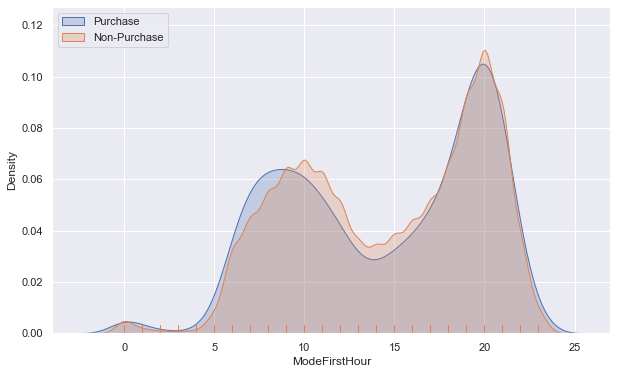

In [32]:
plt.figure(figsize=(10, 6))
sb.distplot(data.loc[data['Label'] == 1]['ModeFirstHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Purchase')
sb.distplot(data.loc[data['Label'] == 0]['ModeFirstHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Non-Purchase')
plt.legend(loc='upper left');

In [33]:
excludes = ['firstPaymentType', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 'TotalChild', 
            'MedianChildAge', 'No.Female', 'No.Male', 'No.TypeBrand', 'BigBrand', 'MediumBrand',
            'SmallBrand', 'Label', 'gapday', 'JoinMonth', 'ModeFirstHour', 'ModeLastHour', 'ModeLastDay',
            'ModeDayofweek']

for col in data.columns[1:]:
    if col not in excludes:
        if data[col].min() == 0:
            data[col] = data[col] + 1
            data[col] = np.log(data[col])
        else:
            data[col] = np.log(data[col])

In [34]:
data.to_csv('ICK_Active5thdays.csv', index=False)

----- TotalUsageTime -----
count    158981.000000
mean          2.700396
std           1.325790
min           0.000000
25%           1.652497
50%           2.758109
75%           3.685624
max           7.447314
Name: TotalUsageTime, dtype: float64
* Variance: 1.7577188144519438
* Median: 2.758109400974947
* Skewness: 0.022007030230685475
* Kurtosis: -0.7607862028081867
* Percentage of outliers: 0.00010064095709550197
* Number of missing value: 0


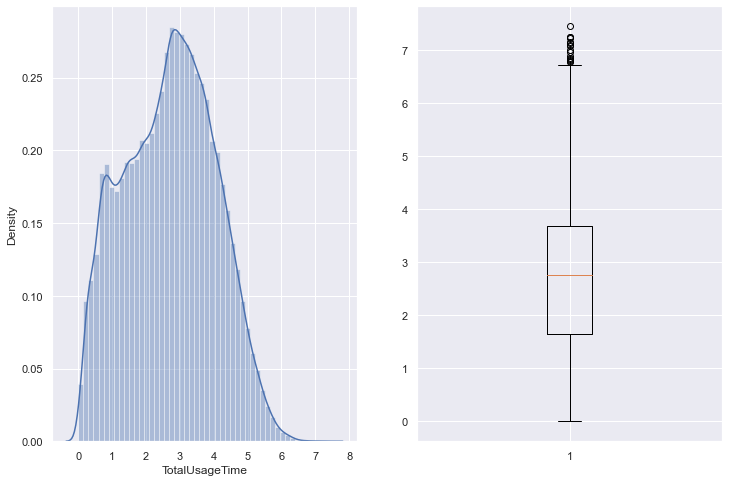


----- TotalRecords -----
count    158981.000000
mean          2.593704
std           1.352890
min           0.000000
25%           1.609438
50%           2.708050
75%           3.583519
max           7.086738
Name: TotalRecords, dtype: float64
* Variance: 1.830312157940798
* Median: 2.70805020110221
* Skewness: -0.17898793013395006
* Kurtosis: -0.6450919540208133
* Percentage of outliers: 3.774035891081324e-05
* Number of missing value: 0


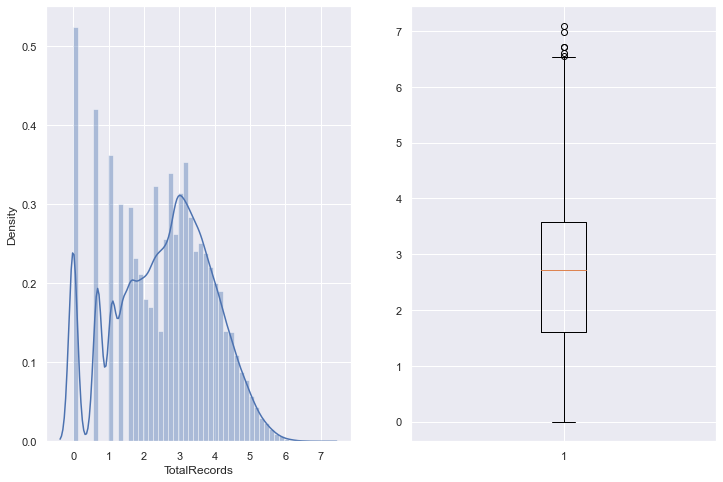


----- InteractionEnglish -----
count    158981.000000
mean          2.139948
std           2.476137
min           0.000000
25%           0.000000
50%           0.765468
75%           4.471182
max          12.124226
Name: InteractionEnglish, dtype: float64
* Variance: 6.131255943896041
* Median: 0.7654678421395714
* Skewness: 0.7078937043166801
* Kurtosis: -0.9215825992727571
* Percentage of outliers: 4.4030418729282114e-05
* Number of missing value: 0


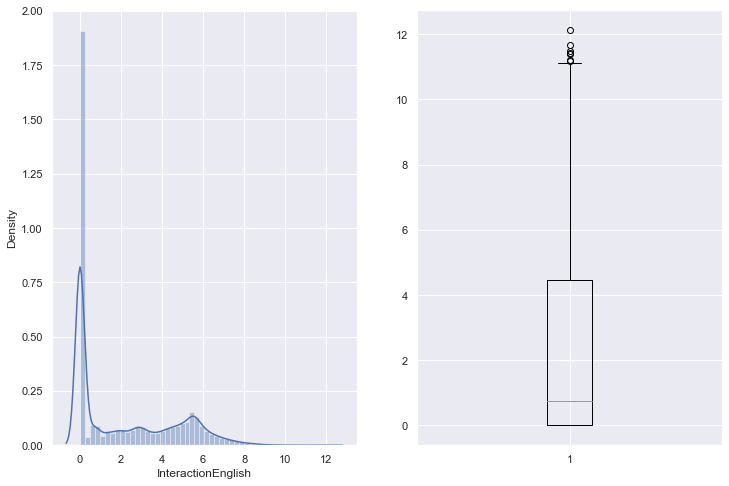


----- InteractionMath -----
count    158981.000000
mean          0.085863
std           0.634134
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.722733
Name: InteractionMath, dtype: float64
* Variance: 0.40212532300388354
* Median: 0.0
* Skewness: 8.663252584851804
* Kurtosis: 81.06162608049698
* Percentage of outliers: 0.028412200200023902
* Number of missing value: 0


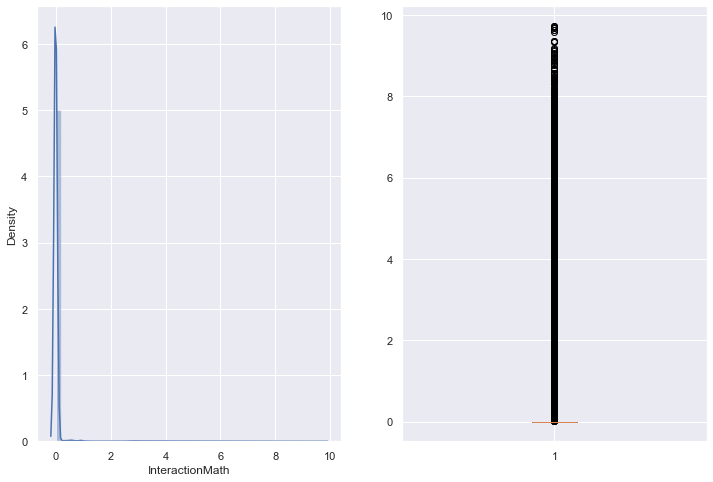


----- InteractionPhonics -----
count    158981.000000
mean          0.097722
std           0.641190
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.217046
Name: InteractionPhonics, dtype: float64
* Variance: 0.41112413250631785
* Median: 0.0
* Skewness: 7.641223697632355
* Kurtosis: 62.95765818054927
* Percentage of outliers: 0.03216736591164982
* Number of missing value: 0


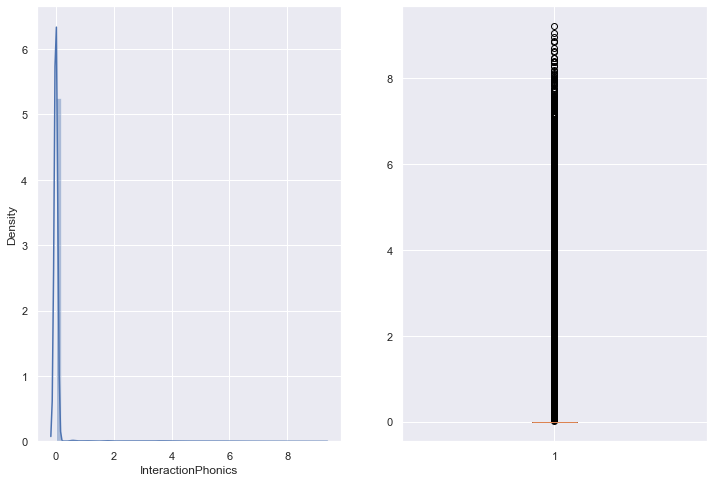


----- InteractionVietnamese -----
count    158981.000000
mean          2.277356
std           2.635401
min           0.000000
25%           0.000000
50%           0.875469
75%           4.550820
max          11.652782
Name: InteractionVietnamese, dtype: float64
* Variance: 6.945338752156726
* Median: 0.8754687373538999
* Skewness: 0.767914739343606
* Kurtosis: -0.7816892741579493
* Percentage of outliers: 1.887017945540662e-05
* Number of missing value: 0


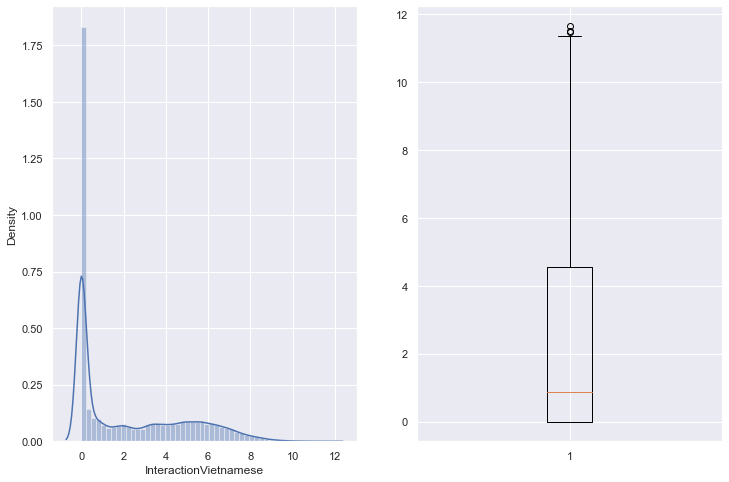


----- IsCompletedEnglish -----
count    158981.000000
mean          0.481953
std           0.509993
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           1.945910
Name: IsCompletedEnglish, dtype: float64
* Variance: 0.2600931810609916
* Median: 0.6931471805599453
* Skewness: 0.5849467510148039
* Kurtosis: -0.6977554086719389
* Percentage of outliers: 0.013422987652612576
* Number of missing value: 0


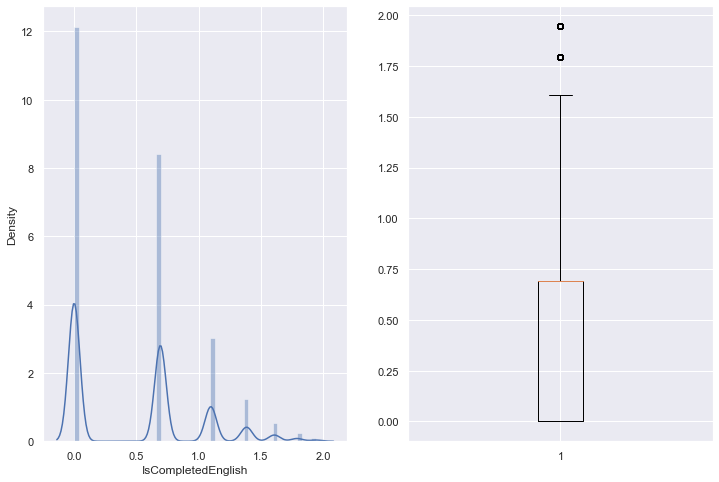


----- IsCompletedMath -----
count    158981.000000
mean          0.022767
std           0.146688
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.945910
Name: IsCompletedMath, dtype: float64
* Variance: 0.021517512765521718
* Median: 0.0
* Skewness: 7.146323041393719
* Kurtosis: 55.881005403291795
* Percentage of outliers: 0.026172938904648984
* Number of missing value: 0


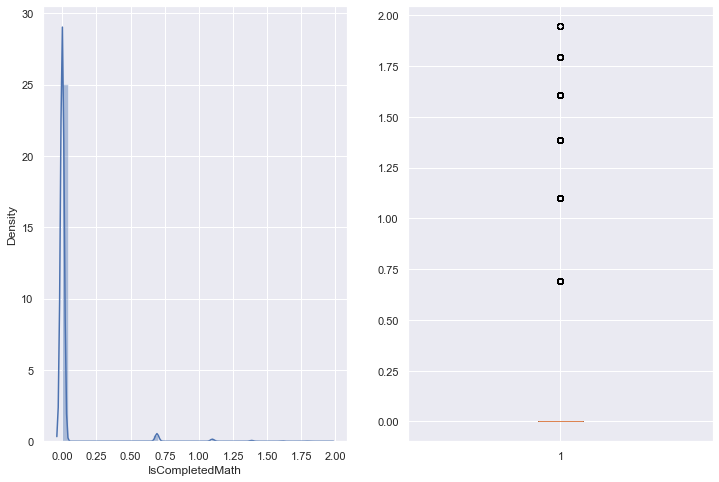


----- IsCompletedPhonics -----
count    158981.000000
mean          0.025014
std           0.150689
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.945910
Name: IsCompletedPhonics, dtype: float64
* Variance: 0.02270705818382249
* Median: 0.0
* Skewness: 6.585451550516221
* Kurtosis: 46.92563318275912
* Percentage of outliers: 0.029456350129889734
* Number of missing value: 0


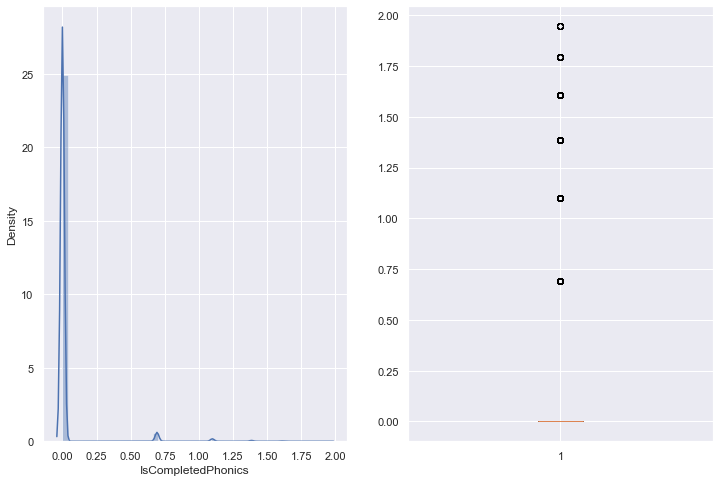


----- IsCompletedVietnamese -----
count    158981.000000
mean          0.503440
std           0.528388
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           1.945910
Name: IsCompletedVietnamese, dtype: float64
* Variance: 0.2791933632961697
* Median: 0.6931471805599453
* Skewness: 0.6084963207659341
* Kurtosis: -0.6334636553959658
* Percentage of outliers: 0.02138620338279417
* Number of missing value: 0


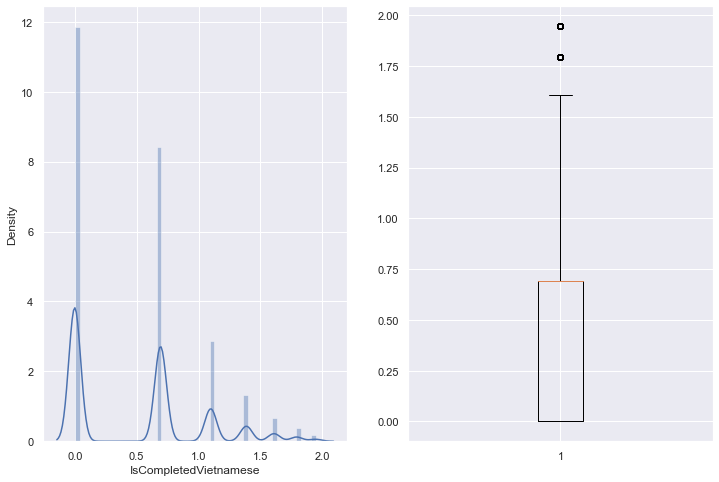


----- RecordEnglish -----
count    158981.000000
mean          1.344639
std           1.451135
min           0.000000
25%           0.000000
50%           1.098612
75%           2.708050
max           6.709304
Name: RecordEnglish, dtype: float64
* Variance: 2.105792851888551
* Median: 1.0986122886681098
* Skewness: 0.5645799212247883
* Kurtosis: -1.0333056881830314
* Percentage of outliers: 0.0
* Number of missing value: 0


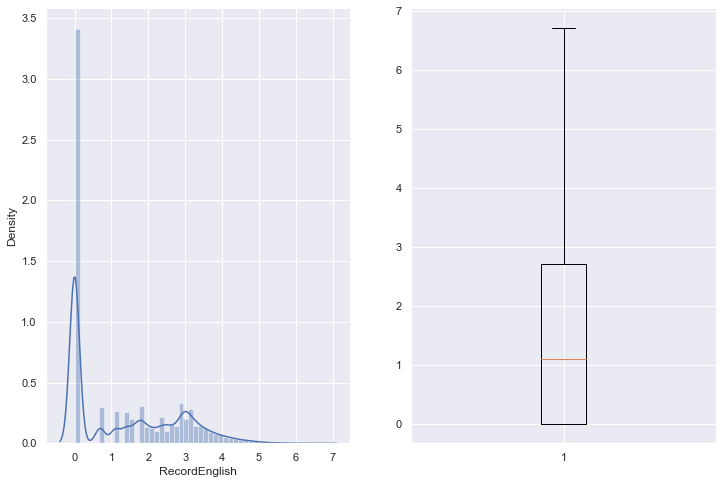


----- RecordMath -----
count    158981.000000
mean          0.056614
std           0.373207
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.375278
Name: RecordMath, dtype: float64
* Variance: 0.1392833500967022
* Median: 0.0
* Skewness: 7.608768638105085
* Kurtosis: 62.81100302908374
* Percentage of outliers: 0.02843107037947931
* Number of missing value: 0


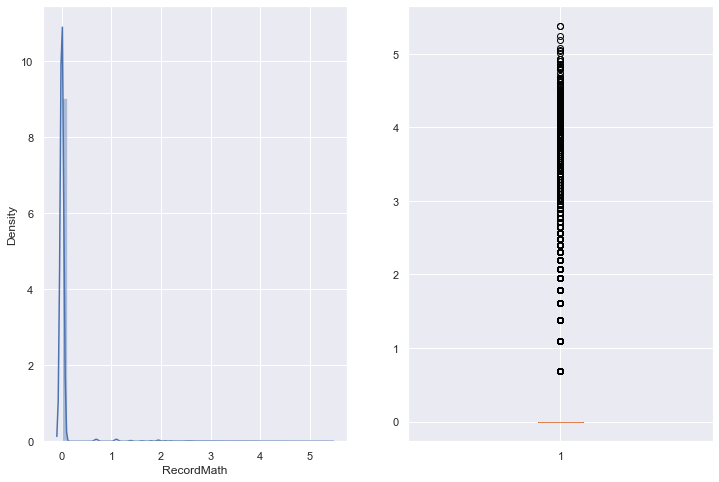


----- RecordPhonics -----
count    158981.000000
mean          0.062563
std           0.382177
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.517453
Name: RecordPhonics, dtype: float64
* Variance: 0.1460590080323076
* Median: 0.0
* Skewness: 6.9783365382281035
* Kurtosis: 52.63889225751553
* Percentage of outliers: 0.032198816210742165
* Number of missing value: 0


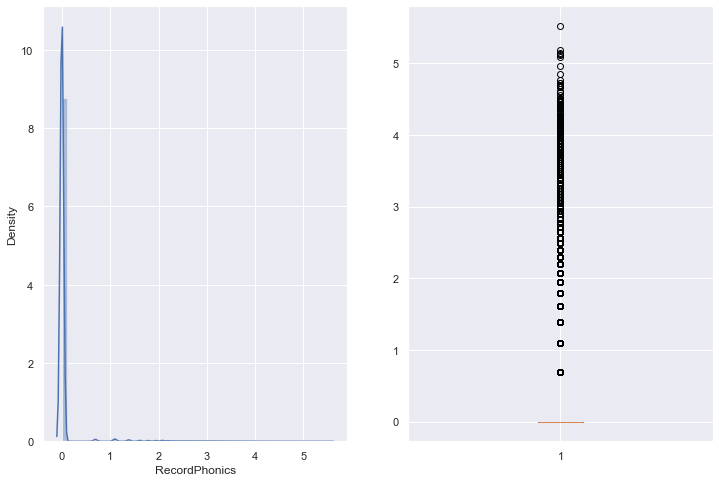


----- RecordVietnamese -----
count    158981.000000
mean          1.385908
std           1.476700
min           0.000000
25%           0.000000
50%           1.098612
75%           2.564949
max           6.651572
Name: RecordVietnamese, dtype: float64
* Variance: 2.1806441418436426
* Median: 1.0986122886681098
* Skewness: 0.6742608238860656
* Kurtosis: -0.7609637696610507
* Percentage of outliers: 3.774035891081324e-05
* Number of missing value: 0


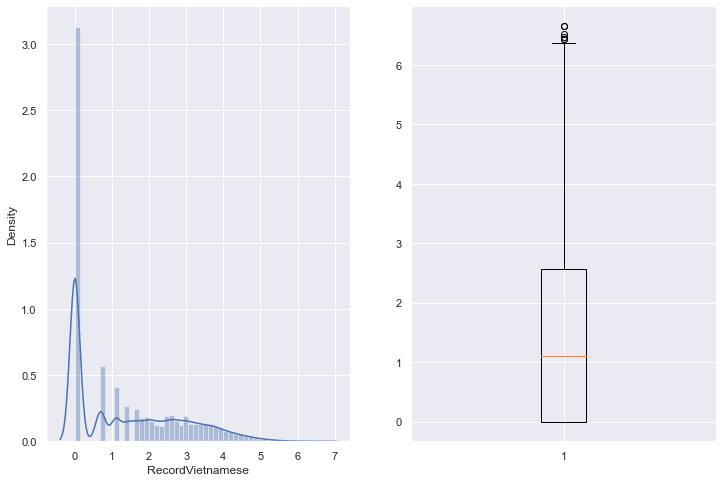


----- UsageTimeEnglish -----
count    158981.000000
mean          1.189659
std           1.338435
min           0.000000
25%           0.000000
50%           0.732368
75%           2.385086
max           7.298066
Name: UsageTimeEnglish, dtype: float64
* Variance: 1.7914084260546372
* Median: 0.7323678937132266
* Skewness: 0.718273708655553
* Kurtosis: -0.7177974683694592
* Percentage of outliers: 0.0001887017945540662
* Number of missing value: 0


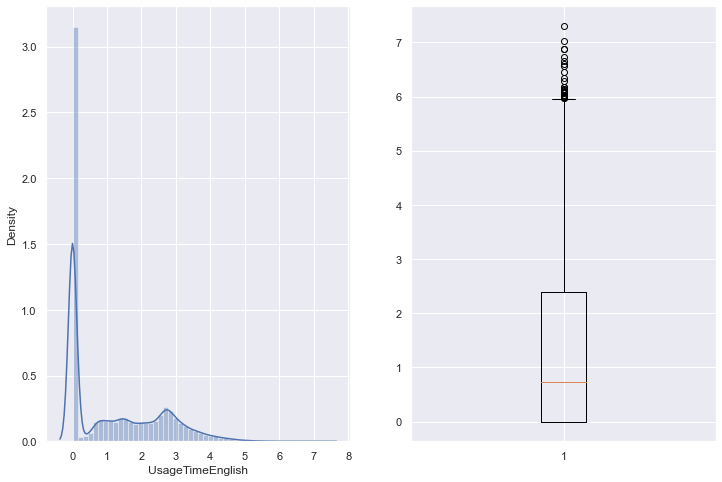


----- UsageTimeMath -----
count    158981.000000
mean          0.050305
std           0.362364
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.141607
Name: UsageTimeMath, dtype: float64
* Variance: 0.13130794292289935
* Median: 0.0
* Skewness: 8.65926263369477
* Kurtosis: 82.56593276663152
* Percentage of outliers: 0.028412200200023902
* Number of missing value: 0


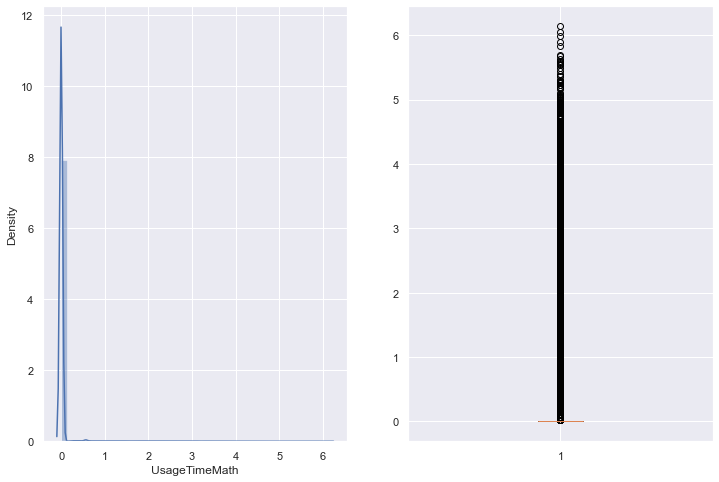


----- UsageTimePhonics -----
count    158981.000000
mean          0.060173
std           0.375294
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.335420
Name: UsageTimePhonics, dtype: float64
* Variance: 0.14084532351719137
* Median: 0.0
* Skewness: 7.146767122670839
* Kurtosis: 55.22900624800426
* Percentage of outliers: 0.03216736591164982
* Number of missing value: 0


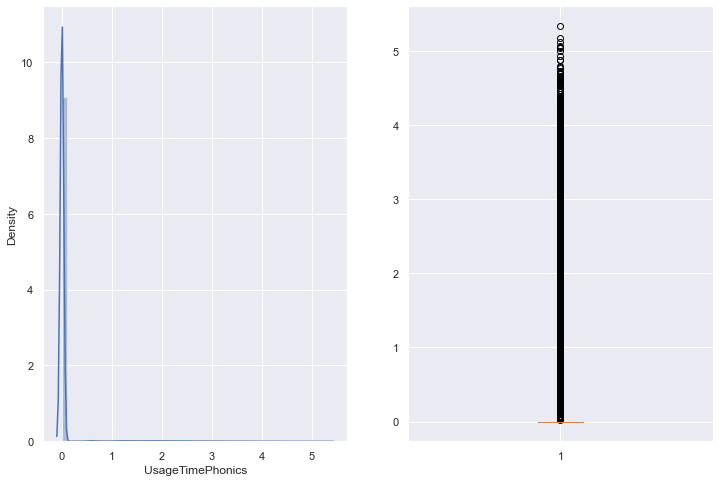


----- UsageTimeVietnamese -----
count    158981.000000
mean          1.303450
std           1.446937
min           0.000000
25%           0.000000
50%           0.741937
75%           2.509599
max           6.719158
Name: UsageTimeVietnamese, dtype: float64
* Variance: 2.09362593726523
* Median: 0.7419373447293773
* Skewness: 0.7251185953112185
* Kurtosis: -0.7404508373742384
* Percentage of outliers: 6.290059818468874e-05
* Number of missing value: 0


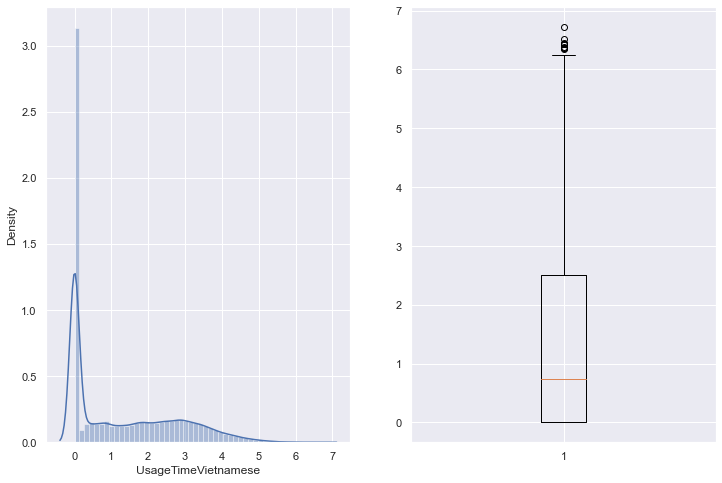


----- RecordDiscovery -----
count    158981.000000
mean          0.652091
std           0.913239
min           0.000000
25%           0.000000
50%           0.000000
75%           1.098612
max           5.283204
Name: RecordDiscovery, dtype: float64
* Variance: 0.8340062186971733
* Median: 0.0
* Skewness: 1.189889678264844
* Kurtosis: 0.2913242687394999
* Percentage of outliers: 0.031789962322541686
* Number of missing value: 0


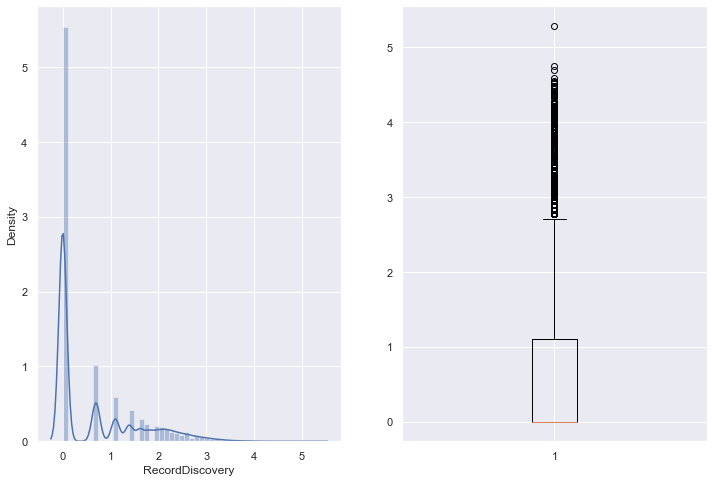


----- RecordEntertainment -----
count    158981.000000
mean          0.783883
std           1.083480
min           0.000000
25%           0.000000
50%           0.000000
75%           1.386294
max           6.003887
Name: RecordEntertainment, dtype: float64
* Variance: 1.1739283455567486
* Median: 0.0
* Skewness: 1.2548721637738447
* Kurtosis: 0.6645635197571482
* Percentage of outliers: 0.02541813172643272
* Number of missing value: 0


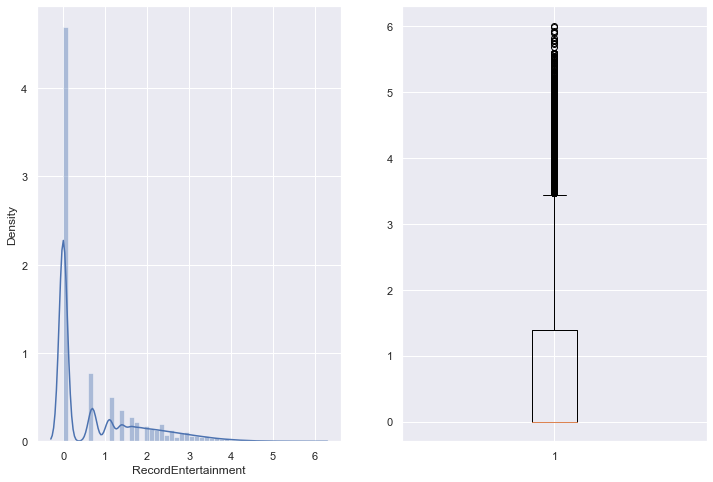


----- RecordLearn -----
count    158981.000000
mean          2.442842
std           1.263771
min           0.000000
25%           1.386294
50%           2.484907
75%           3.332205
max           6.988413
Name: RecordLearn, dtype: float64
* Variance: 1.5971174938616401
* Median: 2.4849066497880004
* Skewness: -0.008592526951824154
* Kurtosis: -0.633078441224173
* Percentage of outliers: 0.00018241173473559734
* Number of missing value: 0


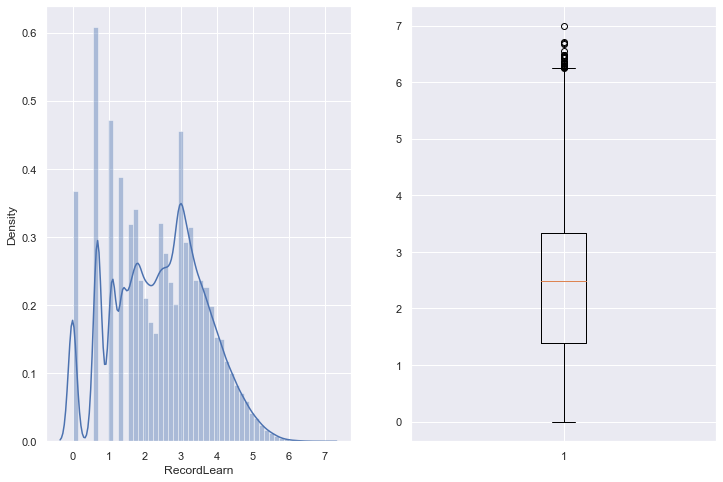


----- UsageTimeDiscovery -----
count    158981.000000
mean          0.846719
std           1.226620
min           0.000000
25%           0.000000
50%           0.000000
75%           1.726332
max           6.025842
Name: UsageTimeDiscovery, dtype: float64
* Variance: 1.504595963659279
* Median: 0.0
* Skewness: 1.1387320253210487
* Kurtosis: -0.09006655873730196
* Percentage of outliers: 0.003880966907995295
* Number of missing value: 0


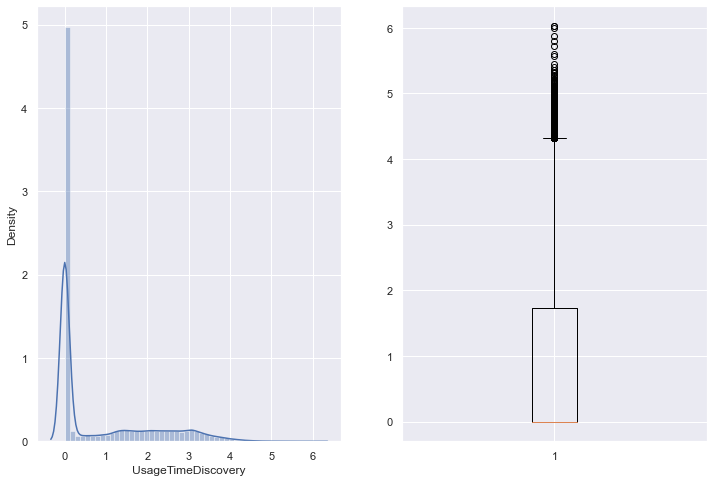


----- UsageTimeEntertainment -----
count    158981.000000
mean          0.880448
std           1.331029
min           0.000000
25%           0.000000
50%           0.000000
75%           1.595339
max           7.145819
Name: UsageTimeEntertainment, dtype: float64
* Variance: 1.7716377063194715
* Median: 0.0
* Skewness: 1.404003103351415
* Kurtosis: 0.8689253058603139
* Percentage of outliers: 0.03721828394588032
* Number of missing value: 0


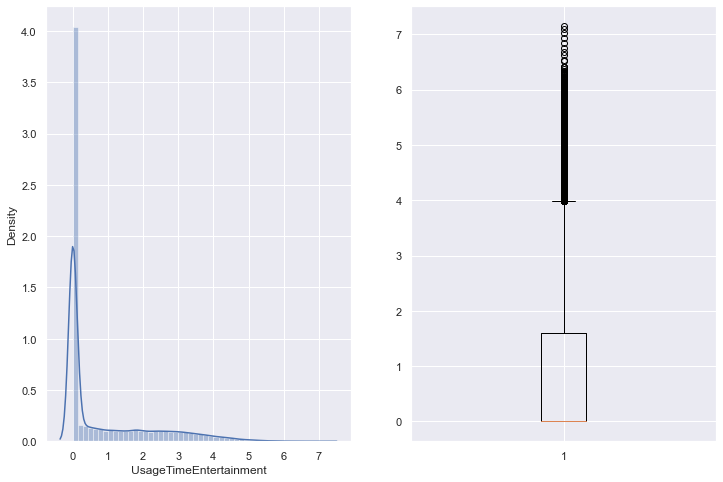


----- UsageTimeLearn -----
count    158981.000000
mean          2.248669
std           1.272091
min           0.000000
25%           1.229641
50%           2.329227
75%           3.164208
max           7.443898
Name: UsageTimeLearn, dtype: float64
* Variance: 1.618214264217303
* Median: 2.329227023940467
* Skewness: 0.061295918548684256
* Kurtosis: -0.6981685828489756
* Percentage of outliers: 0.0003774035891081324
* Number of missing value: 0


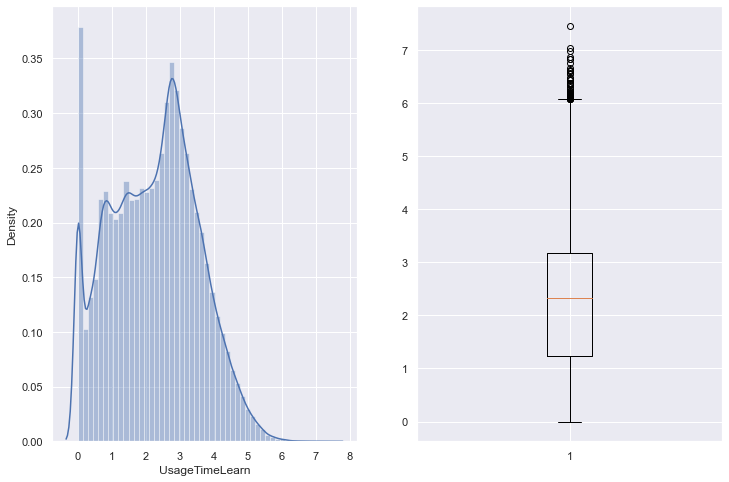


----- MedianUsageTime -----
count    158981.000000
mean          1.838557
std           0.817032
min           0.000000
25%           1.232560
50%           1.876407
75%           2.444085
max           5.448525
Name: MedianUsageTime, dtype: float64
* Variance: 0.6675411175015441
* Median: 1.8764069432883397
* Skewness: -0.022340112771979764
* Kurtosis: -0.5783528431029721
* Percentage of outliers: 0.0009183487334964556
* Number of missing value: 0


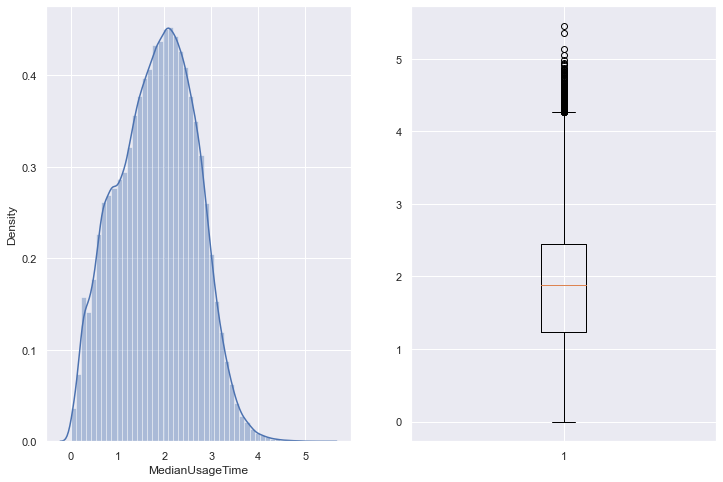


----- MedianRecord -----
count    158981.000000
mean          1.606221
std           0.912095
min           0.000000
25%           1.098612
50%           1.609438
75%           2.302585
max           5.231109
Name: MedianRecord, dtype: float64
* Variance: 0.8319172457090466
* Median: 1.6094379124341003
* Skewness: -0.022133240194022154
* Kurtosis: -0.5685884020484053
* Percentage of outliers: 0.0012139815449644926
* Number of missing value: 0


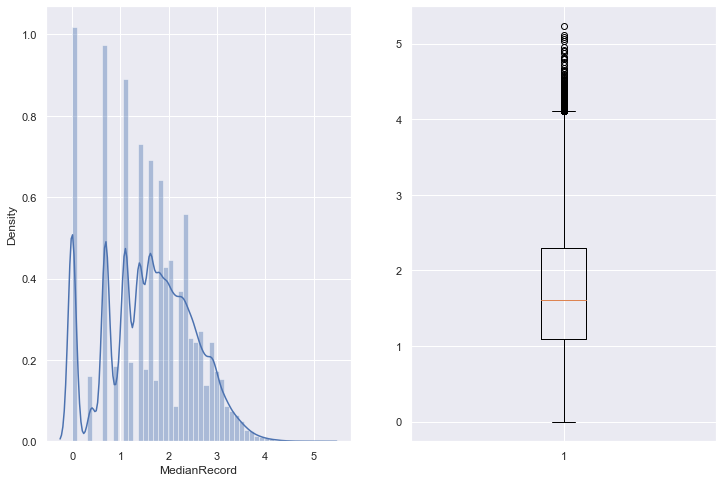


----- MedianPaymentScreen -----
count    158981.000000
mean          0.454469
std           0.656111
min           0.000000
25%           0.000000
50%           0.000000
75%           0.693147
max           5.209486
Name: MedianPaymentScreen, dtype: float64
* Variance: 0.43048153134881545
* Median: 0.0
* Skewness: 1.4426290855262929
* Kurtosis: 1.6984995761172574
* Percentage of outliers: 0.05813273284228933
* Number of missing value: 0


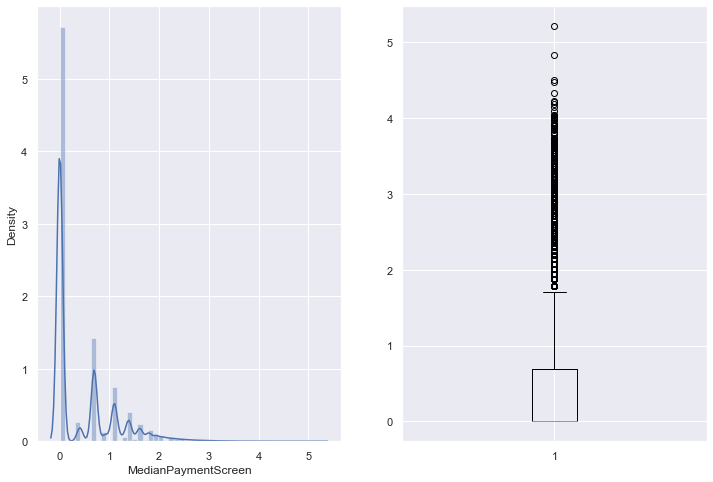


----- AvgTimePerCompletion -----
count    158981.000000
mean          0.681497
std           0.255903
min           0.000000
25%           0.526418
50%           0.639512
75%           0.804241
max           4.224934
Name: AvgTimePerCompletion, dtype: float64
* Variance: 0.06548631036964175
* Median: 0.6395119647273138
* Skewness: 1.1045700502679068
* Kurtosis: 3.3204924304330956
* Percentage of outliers: 0.041344563186795906
* Number of missing value: 0


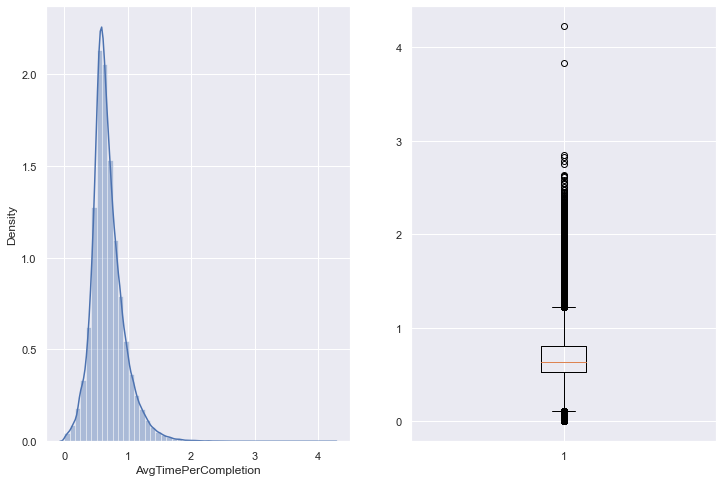


----- InteractionGeneral -----
count    158981.000000
mean          5.210221
std           2.700307
min           0.000000
25%           3.103689
50%           5.446737
75%           7.227895
max          14.216867
Name: InteractionGeneral, dtype: float64
* Variance: 7.291656451867862
* Median: 5.44673737166631
* Skewness: -0.06333228968887476
* Kurtosis: -0.8005865302283013
* Percentage of outliers: 2.5160239273875493e-05
* Number of missing value: 0


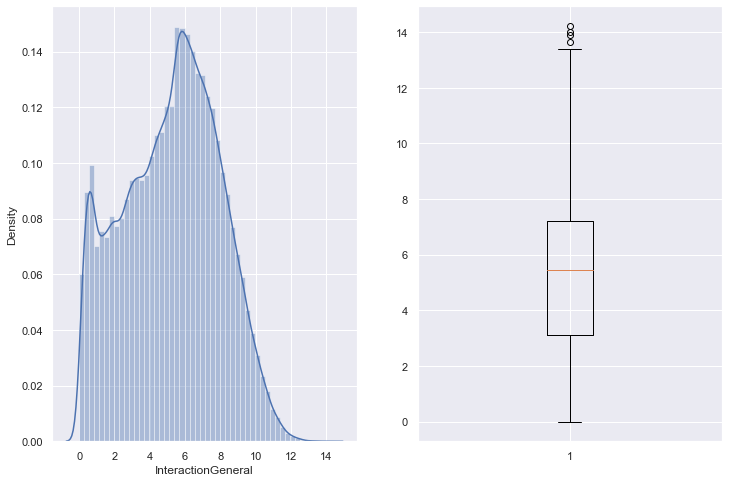


----- InteractionLearn -----
count    158981.000000
mean          4.441350
std           2.689193
min           0.000000
25%           2.198335
50%           4.656053
75%           6.412081
max          13.984343
Name: InteractionLearn, dtype: float64
* Variance: 7.231757817891143
* Median: 4.656053396302661
* Skewness: 0.03518319611059933
* Kurtosis: -0.8523684054036109
* Percentage of outliers: 9.43508972770331e-05
* Number of missing value: 0


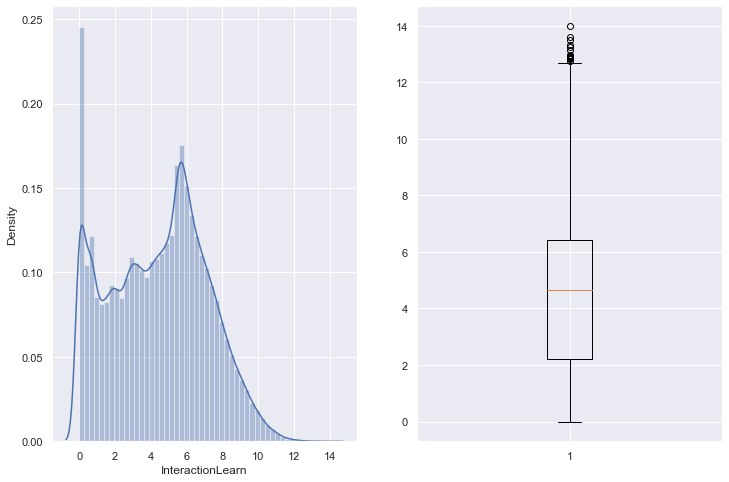


----- InteractionDiscovery -----
count    158981.000000
mean          1.330132
std           2.047969
min           0.000000
25%           0.000000
50%           0.000000
75%           2.465554
max          10.615411
Name: InteractionDiscovery, dtype: float64
* Variance: 4.194178252285655
* Median: 0.0
* Skewness: 1.3610200810205249
* Kurtosis: 0.5957672319107066
* Percentage of outliers: 0.03206043489473585
* Number of missing value: 0


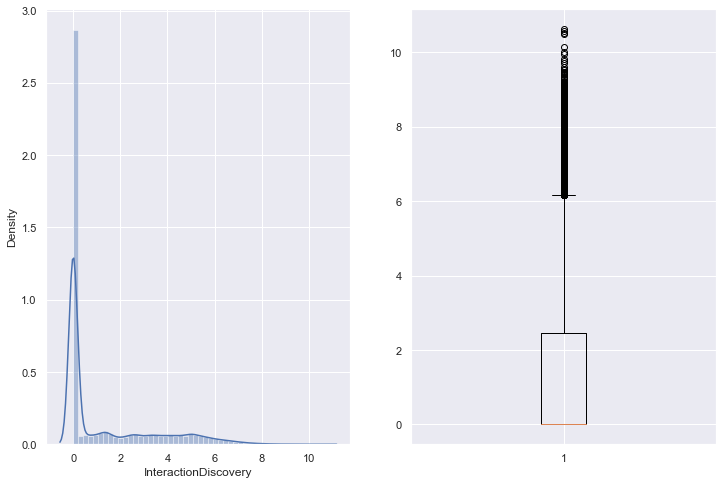


----- InteractionEntertainment -----
count    158981.000000
mean          1.490090
std           2.331284
min           0.000000
25%           0.000000
50%           0.000000
75%           2.583998
max          12.806725
Name: InteractionEntertainment, dtype: float64
* Variance: 5.434884342530004
* Median: 0.0
* Skewness: 1.503545165363059
* Kurtosis: 1.2297071869639962
* Percentage of outliers: 0.05516382460797202
* Number of missing value: 0


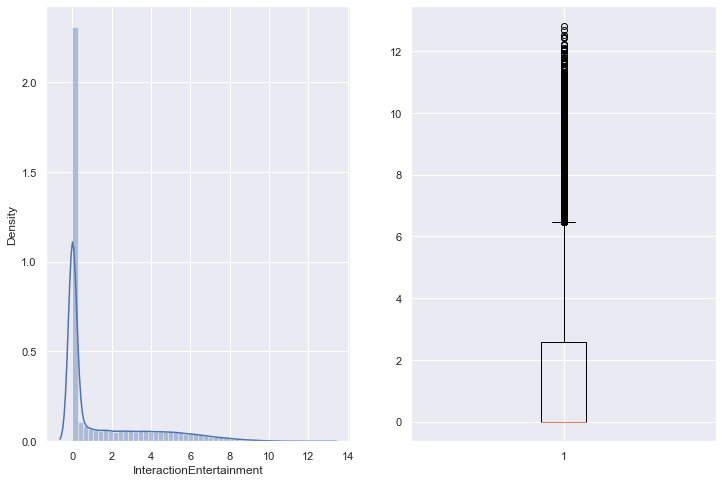


----- MedianInteraction -----
count    158981.000000
mean          3.322221
std           1.693862
min           0.000000
25%           2.028148
50%           3.373741
75%           4.571303
max          10.043499
Name: MedianInteraction, dtype: float64
* Variance: 2.869169075694352
* Median: 3.373740535429116
* Skewness: 0.044919454180901965
* Kurtosis: -0.6658490242018842
* Percentage of outliers: 0.0006415861014838251
* Number of missing value: 0


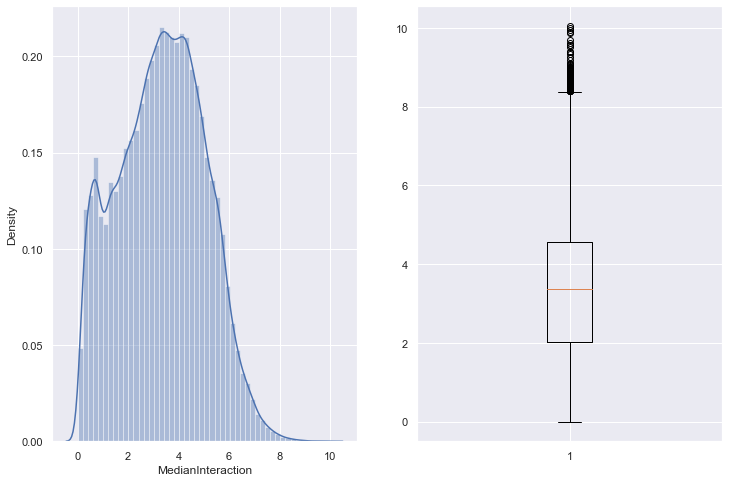

In [35]:
for col in data.columns[1:]:
    if col not in excludes:
        fc.continuous_analysis(data, col)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UserID                    158981 non-null  object 
 1   Recency                   158981 non-null  int64  
 2   ContentFrequent           158981 non-null  int64  
 3   PaymentScreenFrequent     158981 non-null  int64  
 4   TotalUsageTime            158981 non-null  float64
 5   TotalRecords              158981 non-null  float64
 6   ModeFirstHour             158981 non-null  int64  
 7   ModeLastHour              158981 non-null  int64  
 8   ModeLastDay               158981 non-null  int64  
 9   ModeDayofweek             158981 non-null  int64  
 10  TotalChild                158981 non-null  float64
 11  MedianChildAge            158981 non-null  float64
 12  No.Female                 158981 non-null  float64
 13  No.Male                   158981 non-null  f

In [35]:
data

,UserID,Recency,ContentFrequent,PaymentScreenFrequent,TotalUsageTime,TotalRecords,ModeFirstHour,ModeLastHour,ModeLastDay,ModeDayofweek,...,firstPaymentType,JoinMonth,gapday,AvgTimePerCompletion,InteractionGeneral,InteractionLearn,InteractionDiscovery,InteractionEntertainment,MedianInteraction,Label
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,6,1,0,2.927453,2.890372,22,22,11,0,...,NaN,7.0,NaN,0.684219,5.765943,5.765943,0.000000,0.000000,5.765943,0
1,00007f9f-be36-4a0d-a2a8-167231588625,6,1,0,2.060514,1.098612,18,18,12,1,...,NaN,4.0,NaN,1.188859,3.070376,0.000000,3.070376,0.000000,3.070376,0
2,00015787-1ed9-45b9-9c5f-2613e2ca8409,2,11,73,5.083328,4.990433,18,20,18,0,...,NaN,4.0,NaN,0.737424,10.067584,8.832078,8.054904,5.084381,4.328098,0
3,0001f256-edcf-4980-b84b-85d85745fd0f,5,3,0,3.774139,4.110874,8,20,22,4,...,NaN,7.0,NaN,0.529277,7.862174,7.830744,0.488580,0.000000,5.845108,0
4,000234a9-a233-4476-9023-9b83f331b7f6,6,2,0,2.746630,3.295837,18,18,16,6,...,NaN,4.0,NaN,0.432023,5.978709,5.922436,0.239017,0.000000,4.599982,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163035,fffdf7d4-a6c3-46e6-bbb7-045211d7007f,6,1,0,0.392042,0.000000,21,21,13,0,...,NaN,6.0,NaN,0.392042,0.392042,0.392042,0.000000,0.000000,0.392042,0
163036,ffff2125-692f-4755-bfcd-59219e49d6d6,6,1,1,1.613430,1.609438,20,21,12,6,...,NaN,6.0,NaN,0.590006,3.049273,3.049273,0.000000,0.000000,3.049273,0
163037,ffff56de-effe-4b67-9990-33240f51c866,6,2,2,1.418277,1.791759,20,20,3,6,...,NaN,7.0,NaN,0.419806,2.984671,2.656757,0.392042,0.000000,1.739589,0
163038,ffff81a7-4938-4d26-8492-bd8e4acc2a19,4,4,0,3.960051,3.367296,12,12,24,4,...,NaN,6.0,NaN,1.020464,7.308771,2.132982,4.107590,6.619620,3.694302,0


In [36]:
X = data.drop(['UserID', 'Label', 'firstPaymentType', 'gapday'], axis = 1)
y = data['Label']

In [37]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [38]:
def ScaleData(train_data, test_data, method=None):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
    if method==None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'min_max':
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'robust':
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [39]:
X_train_norm, X_test_norm = ScaleData(X_train, X_test, method=None)
X_train_mm, X_test_mm = ScaleData(X_train, X_test, method='min_max')
X_train_rb, X_test_rb = ScaleData(X_train, X_test, method='robust')

In [40]:
sw = fc.BinarySampleWeights(X_train.shape[0], y_train)
sw_zen = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'zen')
sw_isns = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'isns')
sw_eff = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'ens', beta = 0.99999)

In [41]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9441832305950434

In [42]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9448

* Confusion Matrix: 
[[29583   154]
 [ 1600   460]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29737
           1       0.75      0.22      0.34      2060

    accuracy                           0.94     31797
   macro avg       0.85      0.61      0.66     31797
weighted avg       0.94      0.94      0.93     31797



In [43]:
logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train_norm, y_train)

logit_model.score(X_train_norm, y_train)

0.9451975091206442

In [44]:
fc.eval_clf_testset(logit_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9462

* Confusion Matrix: 
[[29590   147]
 [ 1565   495]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     29737
           1       0.77      0.24      0.37      2060

    accuracy                           0.95     31797
   macro avg       0.86      0.62      0.67     31797
weighted avg       0.94      0.95      0.93     31797



In [45]:
import lightgbm as lgbm

lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 100,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9345515159139515

In [46]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9295

* Confusion Matrix: 
[[28353  1384]
 [  859  1201]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.46      0.58      0.52      2060

    accuracy                           0.93     31797
   macro avg       0.72      0.77      0.74     31797
weighted avg       0.94      0.93      0.93     31797



In [47]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 500,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.964036356774437

In [48]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9365

* Confusion Matrix: 
[[28669  1068]
 [  952  1108]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     29737
           1       0.51      0.54      0.52      2060

    accuracy                           0.94     31797
   macro avg       0.74      0.75      0.74     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7510


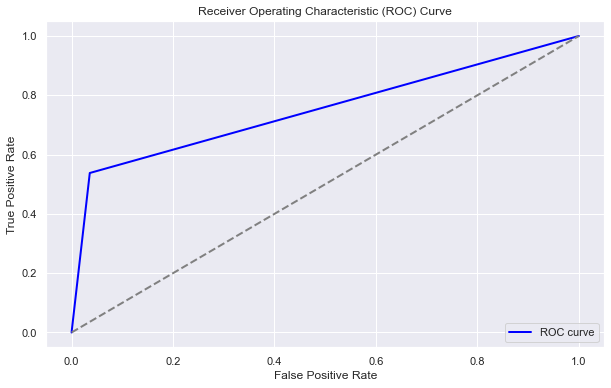

In [49]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test)) 

In [50]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=6,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3
                              )

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9261306453641968

In [51]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9199

* Confusion Matrix: 
[[27977  1760]
 [  787  1273]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     29737
           1       0.42      0.62      0.50      2060

    accuracy                           0.92     31797
   macro avg       0.70      0.78      0.73     31797
weighted avg       0.94      0.92      0.93     31797



ROC AUC score: 0.7794


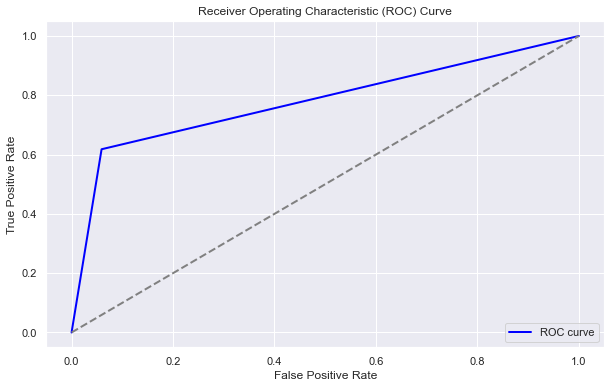

In [175]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [52]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=6,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9677868285318908

In [53]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9357

* Confusion Matrix: 
[[28617  1120]
 [  925  1135]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     29737
           1       0.50      0.55      0.53      2060

    accuracy                           0.94     31797
   macro avg       0.74      0.76      0.75     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7567


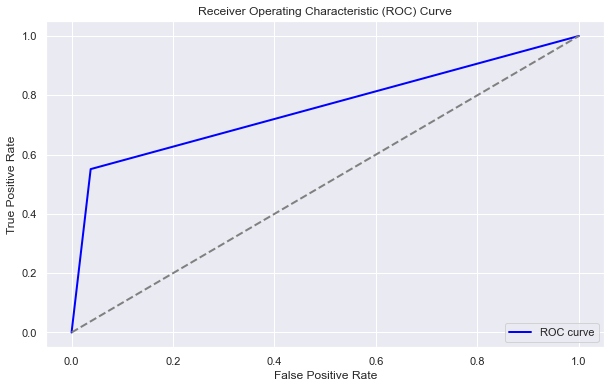

In [54]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [55]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3
                              )

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9423669643980375

In [56]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9372

* Confusion Matrix: 
[[28677  1060]
 [  936  1124]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     29737
           1       0.51      0.55      0.53      2060

    accuracy                           0.94     31797
   macro avg       0.74      0.75      0.75     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7550


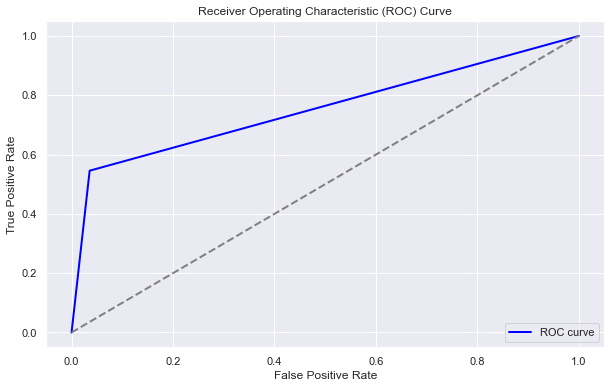

In [57]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [58]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9709633287205938

In [59]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9391

* Confusion Matrix: 
[[28772   965]
 [  970  1090]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.53      0.53      0.53      2060

    accuracy                           0.94     31797
   macro avg       0.75      0.75      0.75     31797
weighted avg       0.94      0.94      0.94     31797



ROC AUC score: 0.7483


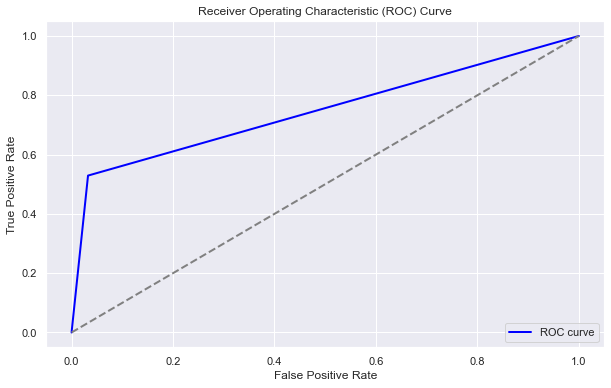

In [60]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [61]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8586378789784879

In [62]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8534

* Confusion Matrix: 
[[25609  4128]
 [  535  1525]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     29737
           1       0.27      0.74      0.40      2060

    accuracy                           0.85     31797
   macro avg       0.62      0.80      0.66     31797
weighted avg       0.93      0.85      0.88     31797



ROC AUC score: 0.8007


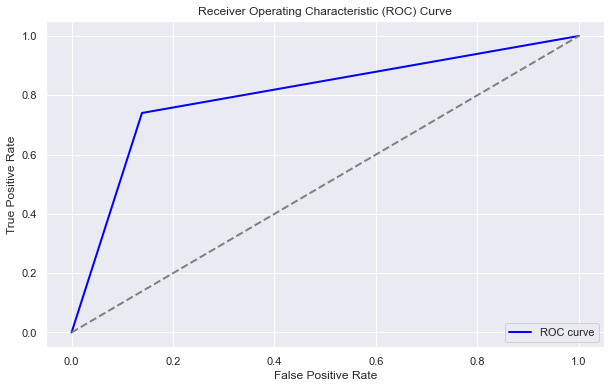

In [63]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [64]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=15,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8479053969052711

In [65]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8458

* Confusion Matrix: 
[[25345  4392]
 [  512  1548]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     29737
           1       0.26      0.75      0.39      2060

    accuracy                           0.85     31797
   macro avg       0.62      0.80      0.65     31797
weighted avg       0.93      0.85      0.88     31797



ROC AUC score: 0.8019


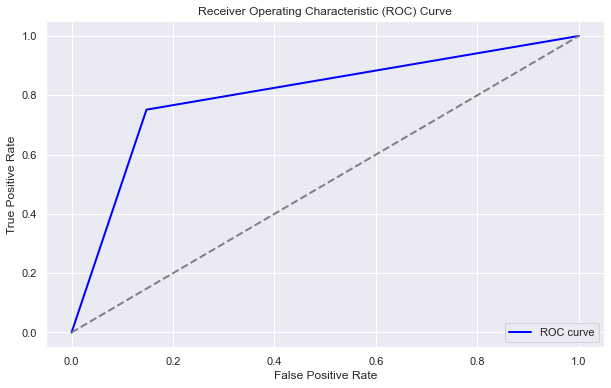

In [66]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [67]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()

gauss_model = gauss.fit(X_train, y_train)
gauss_model.score(X_train, y_train)

0.8079947163165178

In [68]:
fc.eval_clf_testset(gauss_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.808

* Confusion Matrix: 
[[24362  5375]
 [  731  1329]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     29737
           1       0.20      0.65      0.30      2060

    accuracy                           0.81     31797
   macro avg       0.58      0.73      0.60     31797
weighted avg       0.92      0.81      0.85     31797



In [69]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 42)

tree_clf = tree.fit(X_train, y_train)
tree_clf.score(X_train, y_train)

1.0

In [70]:
fc.eval_clf_testset(tree_clf, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9105

* Confusion Matrix: 
[[28161  1576]
 [ 1269   791]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     29737
           1       0.33      0.38      0.36      2060

    accuracy                           0.91     31797
   macro avg       0.65      0.67      0.65     31797
weighted avg       0.92      0.91      0.91     31797



In [71]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.7940385583092213

In [72]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7937

* Confusion Matrix: 
[[23684  6053]
 [  508  1552]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     29737
           1       0.20      0.75      0.32      2060

    accuracy                           0.79     31797
   macro avg       0.59      0.77      0.60     31797
weighted avg       0.93      0.79      0.84     31797



In [73]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.7973329978613662

In [74]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.797

* Confusion Matrix: 
[[23801  5936]
 [  520  1540]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     29737
           1       0.21      0.75      0.32      2060

    accuracy                           0.80     31797
   macro avg       0.59      0.77      0.60     31797
weighted avg       0.93      0.80      0.84     31797



In [75]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9236932318530633

In [76]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9238

* Confusion Matrix: 
[[28378  1359]
 [ 1063   997]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     29737
           1       0.42      0.48      0.45      2060

    accuracy                           0.92     31797
   macro avg       0.69      0.72      0.71     31797
weighted avg       0.93      0.92      0.93     31797



In [77]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.8613740722103409

In [78]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8615

* Confusion Matrix: 
[[26059  3678]
 [  725  1335]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     29737
           1       0.27      0.65      0.38      2060

    accuracy                           0.86     31797
   macro avg       0.62      0.76      0.65     31797
weighted avg       0.93      0.86      0.89     31797



In [79]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [80]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9177

* Confusion Matrix: 
[[28437  1300]
 [ 1318   742]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.36      0.36      0.36      2060

    accuracy                           0.92     31797
   macro avg       0.66      0.66      0.66     31797
weighted avg       0.92      0.92      0.92     31797



In [81]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [82]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9191

* Confusion Matrix: 
[[28484  1253]
 [ 1320   740]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.37      0.36      0.37      2060

    accuracy                           0.92     31797
   macro avg       0.66      0.66      0.66     31797
weighted avg       0.92      0.92      0.92     31797



In [83]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [84]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9144

* Confusion Matrix: 
[[28324  1413]
 [ 1308   752]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     29737
           1       0.35      0.37      0.36      2060

    accuracy                           0.91     31797
   macro avg       0.65      0.66      0.66     31797
weighted avg       0.92      0.91      0.92     31797



In [85]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [86]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.913

* Confusion Matrix: 
[[28300  1437]
 [ 1329   731]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     29737
           1       0.34      0.35      0.35      2060

    accuracy                           0.91     31797
   macro avg       0.65      0.65      0.65     31797
weighted avg       0.92      0.91      0.91     31797



In [101]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42, n_estimators = 100)
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999685495030821

In [102]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9496

* Confusion Matrix: 
[[29624   113]
 [ 1491   569]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     29737
           1       0.83      0.28      0.42      2060

    accuracy                           0.95     31797
   macro avg       0.89      0.64      0.69     31797
weighted avg       0.94      0.95      0.94     31797



In [103]:
forest = RandomForestClassifier(random_state = 42, n_estimators = 100, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999764121273116

In [104]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9492

* Confusion Matrix: 
[[29643    94]
 [ 1522   538]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     29737
           1       0.85      0.26      0.40      2060

    accuracy                           0.95     31797
   macro avg       0.90      0.63      0.69     31797
weighted avg       0.94      0.95      0.94     31797



In [119]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 600,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9434834570386212

In [120]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9375

* Confusion Matrix: 
[[28691  1046]
 [  941  1119]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     29737
           1       0.52      0.54      0.53      2060

    accuracy                           0.94     31797
   macro avg       0.74      0.75      0.75     31797
weighted avg       0.94      0.94      0.94     31797



In [126]:
data.to_csv('ICK_Active5thdays.csv', index=False)

In [127]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

In [128]:
class_weights_dict = dict(enumerate(class_weights))

In [129]:
class_weights_dict

{0: 0.5346379160753559, 1: 7.717524271844661}

In [130]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = class_weights_dict,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8547065668637565

In [131]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8504

* Confusion Matrix: 
[[25515  4222]
 [  536  1524]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.86      0.91     29737
           1       0.27      0.74      0.39      2060

    accuracy                           0.85     31797
   macro avg       0.62      0.80      0.65     31797
weighted avg       0.93      0.85      0.88     31797



In [89]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.9630220782488363

In [90]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.952

* Confusion Matrix: 
[[29526   211]
 [ 1316   744]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     29737
           1       0.78      0.36      0.49      2060

    accuracy                           0.95     31797
   macro avg       0.87      0.68      0.73     31797
weighted avg       0.95      0.95      0.94     31797



In [91]:
xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 900,
                            colsample_bytree=0.5646751146007976,
                            learning_rate=0.1419865761603358,
                            max_bin=824,
                            scale_pos_weight=5,
                            min_child_weight=1,
                            reg_alpha=1.6259583347890365e-07,
                            reg_lambda=2.110691851528507e-08,
                            subsample=0.879020578464637,
                            objective='binary:logistic',
                            max_depth=3,
                            n_jobs=-1,
                            verbosity=0)

xgb_model = xgb_clf.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.9428229966033463

In [92]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9296

* Confusion Matrix: 
[[28393  1344]
 [  894  1166]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.46      0.57      0.51      2060

    accuracy                           0.93     31797
   macro avg       0.72      0.76      0.74     31797
weighted avg       0.94      0.93      0.93     31797



In [121]:
xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 800,
                            reg_lambda=0.02,
                            reg_alpha=0.02,
                            class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                            min_child_weight=0.05,
                            learning_rate=0.055,
                            subsample=0.85,
                            colsample_bytree=0.85,
                            max_depth=3)

xgb_model = xgb_clf.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

                            

0.955151591395144

In [122]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9522

* Confusion Matrix: 
[[29566   171]
 [ 1349   711]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     29737
           1       0.81      0.35      0.48      2060

    accuracy                           0.95     31797
   macro avg       0.88      0.67      0.73     31797
weighted avg       0.95      0.95      0.94     31797



In [117]:
import catboost as cbt

cbt_clf = cbt.CatBoostClassifier(random_state=42, verbose=False, n_estimators=900,
                                 learning_rate=0.055,
                                 scale_pos_weight=4,
                                 max_depth=4)
cbt_model = cbt_clf.fit(X_train, y_train)

cbt_model.score(X_train, y_train)

0.9422097119134483

In [118]:
fc.eval_clf_testset(cbt_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9376

* Confusion Matrix: 
[[28693  1044]
 [  940  1120]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     29737
           1       0.52      0.54      0.53      2060

    accuracy                           0.94     31797
   macro avg       0.74      0.75      0.75     31797
weighted avg       0.94      0.94      0.94     31797



In [128]:
lgb_res = lgbm_model.predict_proba(X_test)[:, 1]

In [129]:
demo = [1 if x >= 0.5 else 0 for x in lgb_res]

In [130]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [131]:
print(classification_report(y_test, demo))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     29737
           1       0.52      0.54      0.53      2060

    accuracy                           0.94     31797
   macro avg       0.74      0.75      0.75     31797
weighted avg       0.94      0.94      0.94     31797



In [132]:
lgb_res = lgbm_model.predict_proba(X_test)[:, 1]
xgb_res = xgb_model.predict_proba(X_test)[:, 1]
cbt_res = cbt_model.predict_proba(X_test)[:, 1]

results = pd.DataFrame({'LightGBM': lgb_res,
                        'XGBoost': xgb_res,
                        'CatBoost': cbt_res})

In [223]:
results['Ensemble'] = results['LightGBM'] * 0.8 + results['CatBoost'] * 0.2

results['Prediction'] = results['Ensemble'].map(lambda x: 1 if x >= 0.5 else 0)

In [224]:
results

,LightGBM,XGBoost,CatBoost,Ensemble,Prediction
0,0.044566,0.011533,0.043683,0.044389,0
1,0.340018,0.098450,0.305395,0.333093,0
2,0.067493,0.020620,0.079445,0.069884,0
3,0.039479,0.010359,0.041364,0.039856,0
4,0.024241,0.005882,0.027768,0.024947,0
...,...,...,...,...,...
31792,0.136399,0.047650,0.108292,0.130778,0
31793,0.137302,0.043458,0.161794,0.142201,0
31794,0.290048,0.103391,0.293418,0.290722,0
31795,0.049527,0.012251,0.057076,0.051037,0


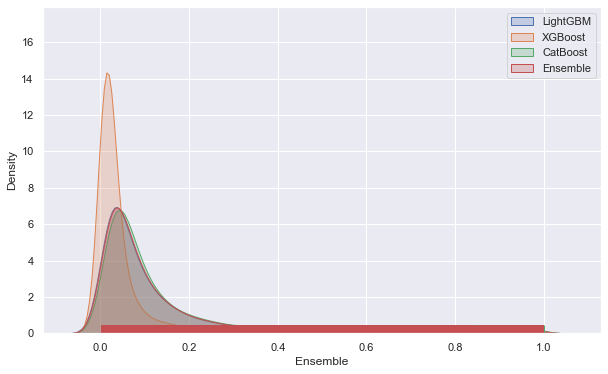

In [225]:
plt.figure(figsize=(10, 6))
sb.distplot(results['LightGBM'], kde_kws={'shade':'kde_kws'},hist = False, rug = True,label='LightGBM')
sb.distplot(results['XGBoost'], kde_kws={'shade':'kde_kws'},hist = False, rug = True,label='XGBoost')
sb.distplot(results['CatBoost'], kde_kws={'shade':'kde_kws'},hist = False, rug = True,label='CatBoost')
sb.distplot(results['Ensemble'], kde_kws={'shade':'kde_kws'},hist = False, rug = True,label='Ensemble')
plt.legend(loc='upper right');

In [214]:
a = np.array([0.044566, 0.011533, 0.043683])

np.median(a)

0.043683

In [215]:
np.median(results['Ensemble'])

0.058516350898494565

In [216]:
np.median(results['LightGBM'])

0.06573363778149442

In [217]:
np.median(results['XGBoost'])

0.019425947

In [218]:
np.median(results['CatBoost'])

0.07212211946453126

In [226]:
print(classification_report(y_test, results['Prediction']))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29737
           1       0.52      0.54      0.53      2060

    accuracy                           0.94     31797
   macro avg       0.74      0.75      0.75     31797
weighted avg       0.94      0.94      0.94     31797



In [165]:
fc.eval_clf_testset(cbt_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9376

* Confusion Matrix: 
[[28693  1044]
 [  940  1120]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     29737
           1       0.52      0.54      0.53      2060

    accuracy                           0.94     31797
   macro avg       0.74      0.75      0.75     31797
weighted avg       0.94      0.94      0.94     31797



In [166]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9522

* Confusion Matrix: 
[[29566   171]
 [ 1349   711]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     29737
           1       0.81      0.35      0.48      2060

    accuracy                           0.95     31797
   macro avg       0.88      0.67      0.73     31797
weighted avg       0.95      0.95      0.94     31797



In [167]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9375

* Confusion Matrix: 
[[28691  1046]
 [  941  1119]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     29737
           1       0.52      0.54      0.53      2060

    accuracy                           0.94     31797
   macro avg       0.74      0.75      0.75     31797
weighted avg       0.94      0.94      0.94     31797



In [136]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy='minority')

X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

In [137]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               scale_pos_weight=5)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9946739642184558

In [138]:
fc.eval_clf_testset(lgbm_model, X_train, y_train)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9901

* Confusion Matrix: 
[[118026    918]
 [   347   7893]]

* Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    118944
           1       0.90      0.96      0.93      8240

    accuracy                           0.99    127184
   macro avg       0.95      0.98      0.96    127184
weighted avg       0.99      0.99      0.99    127184



In [139]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9407

* Confusion Matrix: 
[[28927   810]
 [ 1075   985]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     29737
           1       0.55      0.48      0.51      2060

    accuracy                           0.94     31797
   macro avg       0.76      0.73      0.74     31797
weighted avg       0.94      0.94      0.94     31797



In [140]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1000,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9509264864137745

In [141]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9081

* Confusion Matrix: 
[[27557  2180]
 [  741  1319]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     29737
           1       0.38      0.64      0.47      2060

    accuracy                           0.91     31797
   macro avg       0.68      0.78      0.71     31797
weighted avg       0.94      0.91      0.92     31797

